In [13]:
from readdata import read_images_inorder
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist

training_data, training_labels = read_images_inorder('../Yale_Face_Database/Training/')
testing_data, testing_labels = read_images_inorder('../Yale_Face_Database/Testing/')

In [14]:
def get_A(data):
    # A.T @ A equals to np.cov()
    data_ = np.array(data)
    mean = np.mean(data_,axis=1)
    A = np.array([i-j for (i,j) in zip(data_, mean)])
    A /= np.sqrt(np.size(data_,axis=1)-1)
    return A.T

In [15]:
def get_between_class_discrimination(training_data):
    clustered_traind = training_data.reshape(15,9,45045)

    diff_btw_clus_traind = []
    for i in range(0, 15):
        for j in range(i+1, 15):
            diff_btw_clus_traind.append(clustered_traind[i] - clustered_traind[j])
    diff_btw_clus_traind = np.array(diff_btw_clus_traind)

#     print(diff_btw_clus_traind.shape)

    SB = np.zeros((9,9))
    A = np.zeros((45045,9))
    
#     for i in range(105):
#         SB += np.cov(diff_btw_clus_traind[i])

    for i in range(105):
        tmpA = get_A(diff_btw_clus_traind[i])
        A += tmpA
        SB += tmpA.T @ tmpA
        
    return SB, A

In [16]:
SB, SB_A = get_between_class_discrimination(training_data)
# SB : (105, 9, 45045)

In [17]:
print(SB.shape)

(9, 9)


In [18]:
def get_inner_class_discrimination(training_data):
    clustered_traind = training_data.reshape(15,9,45045)
    SW = np.zeros((9,9))
#     for i in range(15):
#         SW += np.cov(clustered_traind[i])
    A = np.zeros((45045,9))
    for i in range(15):
        tmpA = get_A(clustered_traind[i])
        A += tmpA
        SW += tmpA.T @ tmpA
        
    return SW, A

In [19]:
SW, SW_A = get_inner_class_discrimination(training_data)

In [20]:
print(SW.shape)

(9, 9)


In [21]:
A_BovW = SB_A/SW_A
print(A_BovW.shape)

(45045, 9)


In [22]:
# C = A @ A.T

# sort
vals , vecs = np.linalg.eig(np.linalg.inv(SW)@SB)
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]
vecs = np.flip(vecs,axis=0)
vals = np.flip(vals)

In [23]:
print(A_BovW.shape)
print(vecs.shape)

(45045, 9)
(9, 9)


In [24]:
def generate_eigen_faces(A, vecs):
    eigenfaces = (A@vecs[:9].T).T
    for i in range(9):
        plt.imsave("../output/eigenfaces/LDA/eigenface"+str(i)+".png", eigenfaces[i].reshape(231,195), cmap=plt.cm.gray)
generate_eigen_faces(A_BovW, vecs)

In [25]:
v = A_BovW @ vecs[0]
v1 = A_BovW @ vecs[1]
v2 = A_BovW @ vecs[2]




In [26]:
print(v.shape)

(45045,)


In [27]:
def get_projected(xs,y):
    # projected x onto y
    # xs contains serveral x, projected x onto y, and return ys
    xs_ = np.array(xs)
    y_norm = np.dot(y,y)
    for x in xs_:
        x = y * np.dot(x,y) / y_norm
    return xs_

def k_nearest_neighbor(dists, k, training_labels):
    # dist: distance toward every other points
    # we only utilize (training_points, testing_points) pair
    # spanned by test_num X training_num
    label = np.array(training_labels)
    test_label = []
    for test_points in dists:
        idx = np.argpartition(test_points, k)
        test_label.append( np.argmax( np.bincount( label[idx[:k]] )))
    return test_label

In [28]:
# train_projected = get_projected(training_data, v) + get_projected(training_data, v1) + get_projected(training_data, v2)
# test_projected = get_projected(testing_data, v) + get_projected(testing_data, v1) + get_projected(testing_data, v2)

train_projected = get_projected(training_data, v)
test_projected = get_projected(testing_data, v)

# calculate the distance between each [training data points], [testing data points] pair
dist_testXtrain = cdist(test_projected, train_projected)

test_label = k_nearest_neighbor(dist_testXtrain, 8, training_labels)
print(test_label)

[1, 2, 2, 2, 3, 3, 4, 1, 5, 5, 1, 6, 15, 7, 5, 8, 9, 5, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15]


In [29]:
std_label = testing_labels
rank_list = []
for k in range(1,135):
    test_label = k_nearest_neighbor(dist_testXtrain, k, training_labels)
    cnt = 0
    for i in range(30):
        if test_label[i] == std_label[i]:
            cnt += 1
    rank_list.append(cnt)
print(rank_list)

[26, 25, 25, 24, 26, 25, 26, 24, 23, 24, 24, 24, 26, 26, 23, 23, 22, 23, 20, 22, 20, 19, 21, 19, 19, 19, 17, 18, 18, 18, 17, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 13, 12, 11, 11, 11, 12, 12, 12, 13, 14, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 9, 9, 8, 7, 7, 7, 7, 8, 8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 5, 6, 8, 8, 9, 9, 8, 7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 7, 6, 6, 6, 5, 4, 4, 4, 4, 4, 4, 4, 3, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2]


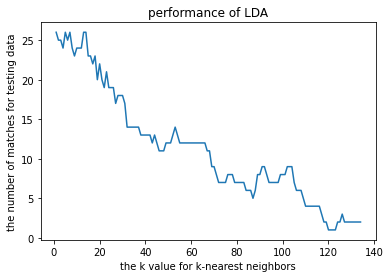

In [31]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,135),rank_list)
plt.title('performance of LDA')
plt.xlabel('the k value for k-nearest neighbors')
plt.ylabel('the number of matches for testing data')
plt.show()

In [30]:
print(train_projected.shape)
print(v.shape)
print(v1.shape)
print(Vs.shape)
print()

(135, 45045)
(45045,)
(45045,)


NameError: name 'Vs' is not defined

In [ ]:
v = A_BovW @ vecs[0]
v1 = A_BovW @ vecs[1]
v2 = A_BovW @ vecs[2]

num_eigen = 10

Vs = np.zeros((num_eigen, 45045))
for i in range(num_eigen):
    Vs[i] = A_BovW @ vecs[i] 

num_project = 10

train_projected = np.zeros(135,45045)
for i in range(num_project):
    train_projected += get_projected(training_data, Vs[i])
    test_projected += get_projected(testing_data, Vs[i])
# train_projected = get_projected(training_data, v)
# test_projected = get_projected(testing_data, v)

# calculate the distance between each [training data points], [testing data points] pair
dist_testXtrain = cdist(test_projected, train_projected)

test_label = k_nearest_neighbor(dist_testXtrain, 8, training_labels)
print(test_label)

In [ ]:
std_label = testing_labels
rank_list = []
for k in range(1,135):
    test_label = k_nearest_neighbor(dist_testXtrain, k, training_labels)
    cnt = 0
    for i in range(30):
        if test_label[i] == std_label[i]:
            cnt += 1
    rank_list.append(cnt)
print(rank_list)